### Libraries

In [1]:
import pickle
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import pylab as plt
from pgmpy.inference import VariableElimination
import pdb
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

### Functions

In [16]:
def get_train_set():
    #Load the processed and normalized  dataset 
    with open('../data/training_population_data_IRL.pkl', 'rb') as f:
        data_full = pickle.load(f)
    initial_state_df = data_full.loc[data_full['Patient_Interval_Number'] == 1.0]
    trim_df = initial_state_df[['Gender', 'Age', 'Daytime_Interval',
                            'Pain_Score','Fatigue_Score','Last_Activitybout_State',
                            'EOD_PAW']]
    rename_df = trim_df.rename(columns={'Daytime_Interval': 'Current Daytime Interval', 
                                    'Pain_Score':'Current Pain',
                                    'Fatigue_Score':'Current Fatigue',
                                    'Last_Activitybout_State': 'Last Acbouts',
                                    'EOD_PAW':'Current EOD PAW'})
    return rename_df


def get_states():
    #State features
    GENDER = ["Male", "Female"] #Dem_02
    AGE = ["Younger than 30", "Between 30 to 60", "60 and Older"] #Dem_01
    DAYTIME_INTERVAL = ["Wake", "Morning", "Afternoon", "Evening", "Bed"] #Morning: 11am, Afternoon: 3pm, Evening: 7pm
    ## Lower: below 33th percentile; Normal: 33rd to 66th percentile; Higher: Above 66th percentile
    PAIN = ["None", "Low", "Medium", "High", "Not Recorded"] #"None" means No_Pain, 1<= Low <=3, 4<= Medium <= 7, 8<= High <= 10
    FATIGUE = ["None", "Low", "Medium", "High", "Not Recorded"] #"None" means No_Fatigue,  
    LAST_ACTIVITYBOUTS = ["Lower", "Normal", "Higher", "Not Recorded"] #used percentile method
    ### 10<= Moderate <=19, 20<= Mild <= 25, Normal >= 26 #Not Applicable
    EOD_PAW = ["None", "Moderate", "Mild", "Normal", "Not Recorded"] 


    states = {}
    state_name_index = 1
    import itertools
    for x in itertools.product(GENDER, AGE, DAYTIME_INTERVAL, PAIN, FATIGUE, LAST_ACTIVITYBOUTS, EOD_PAW):
        if(not(x[2] == "Bed") and not(x[6] == "None")):
            continue
        if(x[2] == "Bed" and x[6] == "None"):
            continue
        #print(x)
        state = {}
        state["Gender"] = x[0]
        state["Age"] = x[1]
        state["Current Daytime Interval"] = x[2]
        state["Current Pain"] = x[3]
        state["Current Fatigue"] = x[4]
        state["Last Acbouts"] = x[5]
        #state["Last Night EOD PAW"] = x[6]
        state["Current EOD PAW"] = x[6]
        state_code = 'S' + str(state_name_index)
        states[state_code] = state
        state_name_index += 1
        
    return states
    

def state_to_state_code(state):
    #input: state
    #output: state_code
    return list(states.keys())[list(states.values()).index(state)]

def get_joint(patient):
    test = infer.query(['Current Pain','Current Fatigue'], evidence = {'Gender':patient['Gender'],'Age':patient['Age']}, joint = True, show_progress=False)
    matrix = test.values

    r = pain_dict[patient['Current Pain']]
    c = fatigue_dict[patient['Current Fatigue']]

    p_pf = matrix[r][c]
    return p_pf

def get_probability(patient):
    p_a = age_prob[age_dict[patient['Age']]]
    p_g = gender_prob[gender_dict[patient['Gender']]]
    p_pf = get_joint(patient)
    prob = p_a * p_g * p_pf
    return prob

def get_patient_IDs():
    PATIENT_ID = []   #total 20 patients , missing patient_id: 1017, 1021; last patient id:1008
    for i in range(1001, 1111, 1): #original 1111
        if(i== 1017 or i == 1021 or i == 1051):
            pass
        else:
            PATIENT_ID.append(str(i))
    return PATIENT_ID

def get_complete_dataset(patient_list,state_codes,probability_list):
    data = list(zip(patient_list, state_codes, probability_list))
    df = pd.DataFrame(data=data,columns =['PATIENT_ID','STATE_CODE','PROBABILITY'])
    return df


### Get Training Dataset - Wake State Only

In [3]:
wake_df = get_train_set()
wake_df

,Gender,Age,Current Daytime Interval,Current Pain,Current Fatigue,Last Acbouts,Current EOD PAW
0,Female,Between 30 to 60,Wake,Low,Low,Not Recorded,None
30,Female,Between 30 to 60,Wake,Low,Low,Not Recorded,None
60,Male,Between 30 to 60,Wake,Low,Low,Not Recorded,None
90,Female,Between 30 to 60,Wake,None,Medium,Not Recorded,None
120,Female,Between 30 to 60,Wake,Medium,Medium,Not Recorded,None
...,...,...,...,...,...,...,...
3060,Female,Between 30 to 60,Wake,Low,Low,Not Recorded,None
3090,Female,Between 30 to 60,Wake,Low,Low,Not Recorded,None
3120,Male,Between 30 to 60,Wake,Medium,None,Not Recorded,None
3150,Female,Between 30 to 60,Wake,Medium,Medium,Not Recorded,None


### Contruct Bayesian Network

<IPython.core.display.Javascript object>


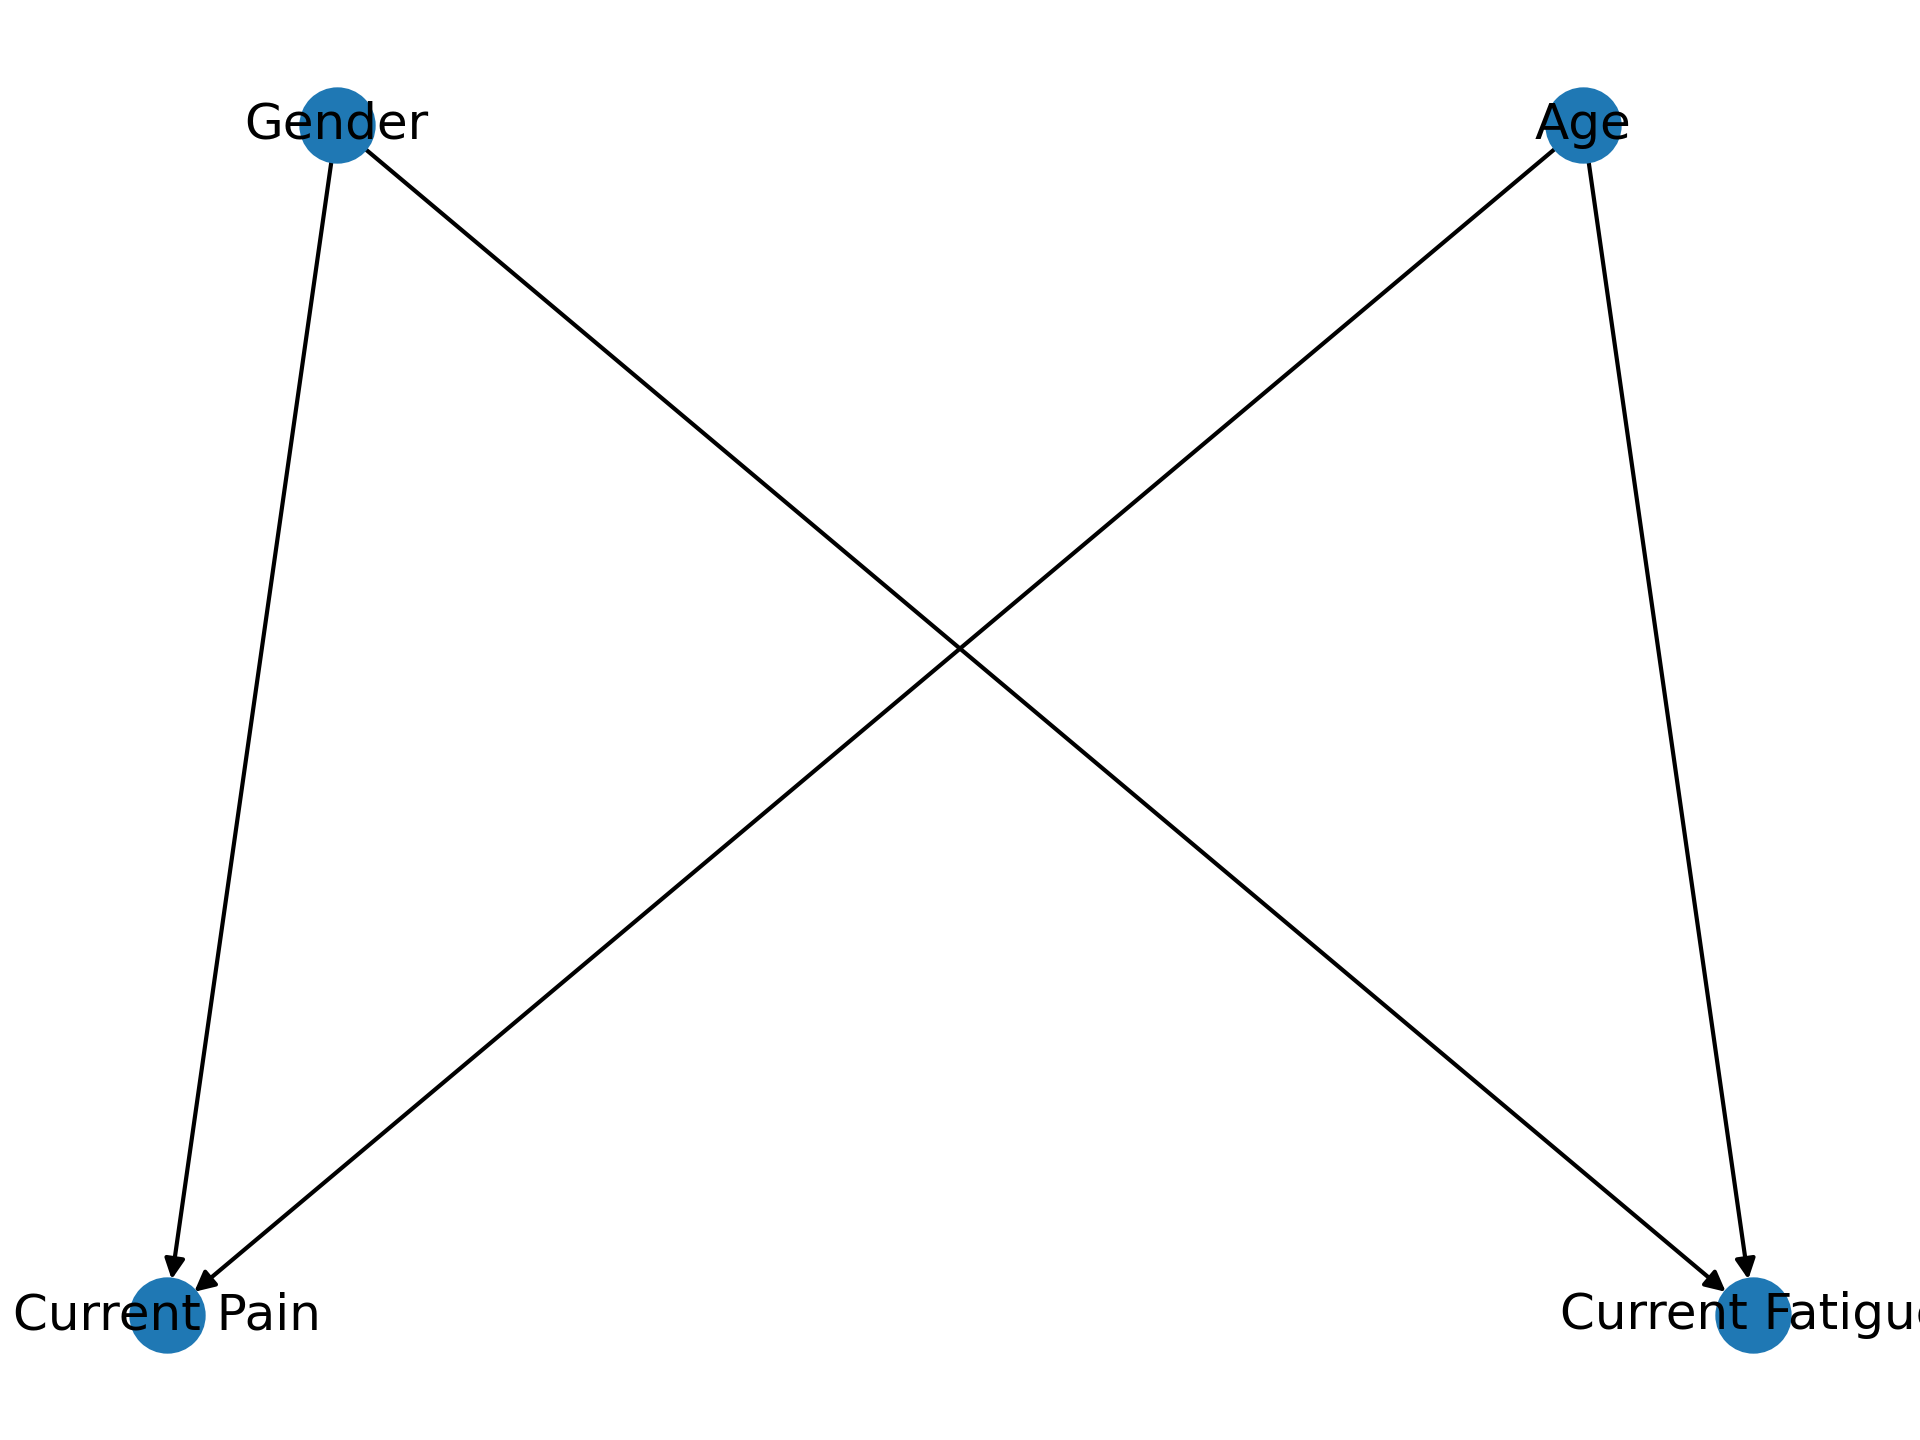

In [4]:
list_of_tup = [('Gender', 'Current Pain'),('Gender', 'Current Fatigue'),
              ('Age', 'Current Pain'), ('Age', 'Current Fatigue'),
              ]
               
model = BayesianModel(list_of_tup)
%matplotlib notebook
#Draw
# nx.draw(model, with_labels=True)
# plt.show()
pos = graphviz_layout(model, prog = 'dot')
nx.draw(model,with_labels=True, pos = pos)

### Train Network

In [5]:
model.fit(wake_df, estimator=BayesianEstimator)

### Infer

In [6]:
infer = VariableElimination(model)

In [7]:
#Age
age_cpds = model.get_cpds("Age")
age_prob = age_cpds.values
age_dict = age_cpds.name_to_no['Age']

print(age_cpds)

+-----------------------+----------+
| Age(60 and Older)     | 0.113095 |
+-----------------------+----------+
| Age(Between 30 to 60) | 0.755952 |
+-----------------------+----------+
| Age(Younger than 30)  | 0.130952 |
+-----------------------+----------+


In [8]:
#Gender
gender_cpds = model.get_cpds("Gender")
gender_prob = gender_cpds.values
gender_dict = gender_cpds.name_to_no['Gender']

print(gender_cpds)

+----------------+----------+
| Gender(Female) | 0.683036 |
+----------------+----------+
| Gender(Male)   | 0.316964 |
+----------------+----------+


In [9]:
#Joint Probability of Pain and Fatigue
pain_cpds = model.get_cpds("Current Pain")
pain_prob = pain_cpds.values
pain_dict = pain_cpds.name_to_no["Current Pain"]

fatigue_cpds = model.get_cpds("Current Fatigue")
fatigue_prob = fatigue_cpds.values
fatigue_dict = fatigue_cpds.name_to_no["Current Fatigue"]

### For each row, get state code and probability

In [10]:
#Initialize:
states = get_states()
state_codes = ['0']*len(wake_df.index)
prob = np.zeros(len(wake_df.index))

In [12]:
for i in range(1, len(wake_df.index)+1):
    row = wake_df[i-1:i]
    patient = row.to_dict('records')[0]
    state_codes[i-1] = state_to_state_code(patient)
    p_a = age_prob[age_dict[patient['Age']]]
    p_g = gender_prob[gender_dict[patient['Gender']]]
    p_pf = get_joint(patient)
    proba = p_a * p_g * p_pf
    prob[i-1] = proba

### Create Dataframe

In [24]:
patient_ids = get_patient_IDs()

df = get_complete_dataset(patient_ids, state_codes, prob)
df

,PATIENT_ID,STATE_CODE,PROBABILITY
0,1001,S3228,0.083392
1,1002,S3228,0.083392
2,1003,S828,0.015209
3,1004,S3212,0.036576
4,1005,S3252,0.018477
...,...,...,...
102,1106,S3228,0.083392
103,1107,S3228,0.083392
104,1108,S844,0.023946
105,1109,S3252,0.018477


In [25]:
#Save Dataframe:
df.to_csv('../data/patient_statecode_probability.csv')